In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [2]:
data = pd.read_csv('./Asset/data.csv', index_col = 'Date')
data = data.iloc[:2665, :]
data

,Open,High,Low,Close,Volume,7ma,14ma,21ma,7macd,14macd,...,21rsv,SQUARE_PHARMA,LHBL,RAK_CERAMIC,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
6/13/2010,327.9,334.0,321.5,330.6,4282600,327.329956,336.804907,347.692319,11.605171,22.988244,...,11.348898,2953.00,512.75,207.8,218.213045,235.579445,223.832615,215.373199,222.749952,228.204727
6/15/2010,330.0,332.6,326.0,326.9,1223300,327.648100,334.651686,344.306797,7.899987,21.585224,...,8.949416,3086.00,539.25,183.9,218.516951,236.698479,226.283623,221.922412,243.420415,253.514806
6/16/2010,330.0,331.0,323.0,324.6,2334600,326.886075,333.311461,342.515232,6.833465,20.791082,...,8.098592,3105.75,539.00,172.8,218.666063,237.253956,227.509335,225.200437,253.331452,265.187952
6/17/2010,328.5,332.9,324.1,325.6,4229700,326.564556,332.283266,340.977454,5.926798,19.940657,...,9.077705,3063.25,549.25,191.2,218.813278,237.806674,228.734885,228.476537,262.817993,275.974472
6/20/2010,325.0,328.0,315.0,318.1,2376500,324.448417,330.392164,338.897650,5.760500,19.208467,...,26.315789,3086.50,568.75,185.9,218.958592,238.356581,229.960046,231.747557,271.783336,285.732230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5/19/2022,134.0,136.8,130.2,132.1,4006075,138.500265,141.664390,143.414046,3.394933,2.286910,...,0.000000,221.90,71.10,41.0,189.146478,165.763765,129.426395,146.379049,138.755841,140.131891
5/22/2022,135.9,135.9,125.5,125.9,2755183,135.350199,139.562471,141.821860,4.494766,2.844877,...,0.000000,220.10,70.50,41.0,189.485512,166.324694,129.640487,146.085557,138.733882,138.623355
5/23/2022,130.0,134.9,129.0,131.1,3735651,134.287649,138.434142,140.847145,4.932650,3.340159,...,22.608696,220.90,69.30,42.6,189.823273,166.887685,129.865577,145.766696,138.683857,137.038797


In [3]:
data['y'] = data['Close']

x = data.iloc[:, :34].values
y = data.iloc[:, 34].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (2132, 34) trainY: (2132,)
testX: (533, 34) testY: (533,)


In [4]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [5]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([34, 400, 400, 400, 10], 10)

[1/300] Loss: 468.90389823913574
[2/300] Loss: 418.32029151916504
[3/300] Loss: 387.2535400390625
[4/300] Loss: 359.65736865997314
[5/300] Loss: 346.77424335479736
[6/300] Loss: 350.643835067749
[7/300] Loss: 352.7566041946411
[8/300] Loss: 339.12345123291016
[9/300] Loss: 323.90002155303955
[10/300] Loss: 318.01322078704834
[11/300] Loss: 315.85910987854004
[12/300] Loss: 309.746919631958
[13/300] Loss: 297.99818420410156
[14/300] Loss: 283.4805498123169
[15/300] Loss: 273.39971446990967
[16/300] Loss: 274.1234712600708
[17/300] Loss: 282.87604904174805
[18/300] Loss: 283.2144079208374
[19/300] Loss: 267.0628957748413
[20/300] Loss: 249.4292697906494
[21/300] Loss: 242.40360164642334
[22/300] Loss: 243.2654571533203
[23/300] Loss: 244.82911586761475
[24/300] Loss: 242.79870891571045
[25/300] Loss: 236.29061603546143
[26/300] Loss: 226.91714763641357
[27/300] Loss: 218.17146396636963
[28/300] Loss: 213.53594207763672
[29/300] Loss: 214.44355487823486
[30/300] Loss: 217.27782344818115
[

[243/300] Loss: 32.75825834274292
[244/300] Loss: 32.770466446876526
[245/300] Loss: 32.73505353927612
[246/300] Loss: 32.60956621170044
[247/300] Loss: 32.441259026527405
[248/300] Loss: 32.19856584072113
[249/300] Loss: 31.916156768798828
[250/300] Loss: 31.593903183937073
[251/300] Loss: 31.301727414131165
[252/300] Loss: 30.991332411766052
[253/300] Loss: 30.73356556892395
[254/300] Loss: 30.548062324523926
[255/300] Loss: 30.398682594299316
[256/300] Loss: 30.31052339076996
[257/300] Loss: 30.275347352027893
[258/300] Loss: 30.281357407569885
[259/300] Loss: 30.304438829421997
[260/300] Loss: 30.343838572502136
[261/300] Loss: 30.389322519302368
[262/300] Loss: 30.40693199634552
[263/300] Loss: 30.401795864105225
[264/300] Loss: 30.327592492103577
[265/300] Loss: 30.18196451663971
[266/300] Loss: 30.010746479034424
[267/300] Loss: 29.802042961120605
[268/300] Loss: 29.629530668258667
[269/300] Loss: 29.454550743103027
[270/300] Loss: 29.312102913856506
[271/300] Loss: 29.181379556

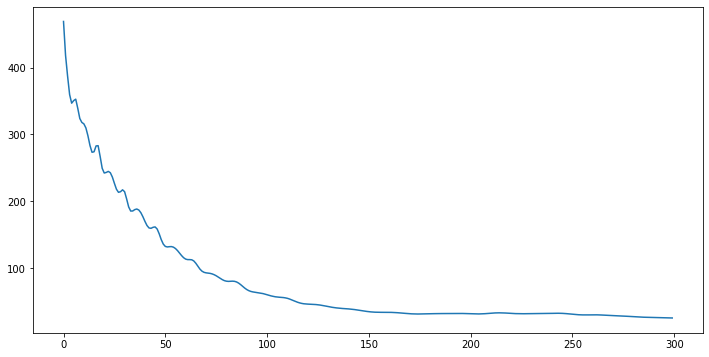

In [6]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [7]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [8]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [9]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [10]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([2129, 3, 44]) train_y: torch.Size([2129, 1]) train_y_gan: torch.Size([2129, 4, 1])
test_x: torch.Size([530, 3, 44]) test_y: torch.Size([530, 1]) test_y_gan: torch.Size([530, 4, 1])


In [11]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

In [13]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000164
num_epochs = 300

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_slide), batch_size = batch_size, shuffle = False)

model = Generator(44).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss_ = []
    y_pred = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)
        y_train_pred = model(x)
        loss = criterion(y_train_pred, y)
        loss_.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))



[1/300] Loss: 2.1815380538610043
[2/300] Loss: 0.6565207517705858
[3/300] Loss: 0.07877486970392056
[4/300] Loss: 0.12850629969034344
[5/300] Loss: 0.454162604175508
[6/300] Loss: 0.1256726668216288
[7/300] Loss: 0.4295389173348667
[8/300] Loss: 0.15393865754595026
[9/300] Loss: 0.4424068327934947
[10/300] Loss: 0.07451870405930094
[11/300] Loss: 0.12613348559534643
[12/300] Loss: 0.12187018390977755
[13/300] Loss: 0.2677006485173479
[14/300] Loss: 0.0916928381921025
[15/300] Loss: 0.16416281915007858
[16/300] Loss: 0.09902321397385094
[17/300] Loss: 0.17504804929922102
[18/300] Loss: 0.0905971040338045
[19/300] Loss: 0.15189950622880133
[20/300] Loss: 0.08817528939107433
[21/300] Loss: 0.151424045136082
[22/300] Loss: 0.08286767729441635
[23/300] Loss: 0.1411429344516364
[24/300] Loss: 0.07826100799138658
[25/300] Loss: 0.13334815113194054
[26/300] Loss: 0.0775663077365607
[27/300] Loss: 0.1351633845406468
[28/300] Loss: 0.0762807120627258
[29/300] Loss: 0.12041772459633648
[30/300] L

[231/300] Loss: 0.019692589801707072
[232/300] Loss: 0.016887223267985974
[233/300] Loss: 0.01975340236822376
[234/300] Loss: 0.01645814176663407
[235/300] Loss: 0.01961768749242765
[236/300] Loss: 0.019989233027445152
[237/300] Loss: 0.026566689790342934
[238/300] Loss: 0.025665707613370614
[239/300] Loss: 0.032415027260867646
[240/300] Loss: 0.029725593092734925
[241/300] Loss: 0.03915839279216016
[242/300] Loss: 0.030813013217994012
[243/300] Loss: 0.03429066749231424
[244/300] Loss: 0.020417812214873265
[245/300] Loss: 0.019490497412334662
[246/300] Loss: 0.018861344284232473
[247/300] Loss: 0.023069960603606887
[248/300] Loss: 0.019189112885214854
[249/300] Loss: 0.02215308648374048
[250/300] Loss: 0.01900028737509274
[251/300] Loss: 0.02326407385407947
[252/300] Loss: 0.024193141056457534
[253/300] Loss: 0.029918864347564522
[254/300] Loss: 0.021511428614758188
[255/300] Loss: 0.02456836430792464
[256/300] Loss: 0.02180439295989345
[257/300] Loss: 0.026489556206797715
[258/300] L

Text(0.5, 0, 'Days')

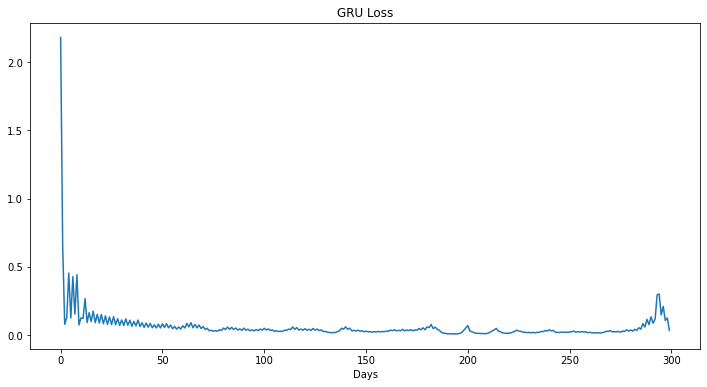

In [14]:
plt.figure(figsize = (12, 6))
plt.plot(hist, label = 'Loss')
plt.title('GRU Loss')
plt.xlabel('Days')


In [15]:
model.eval()
pred_y_train = model(train_x_slide.to(device))
pred_y_test = model(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:10.734098597792558


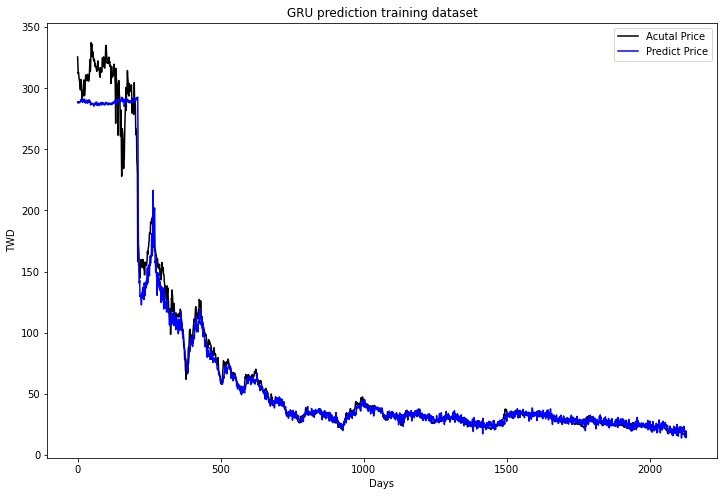

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GRU prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:12.807199748810309


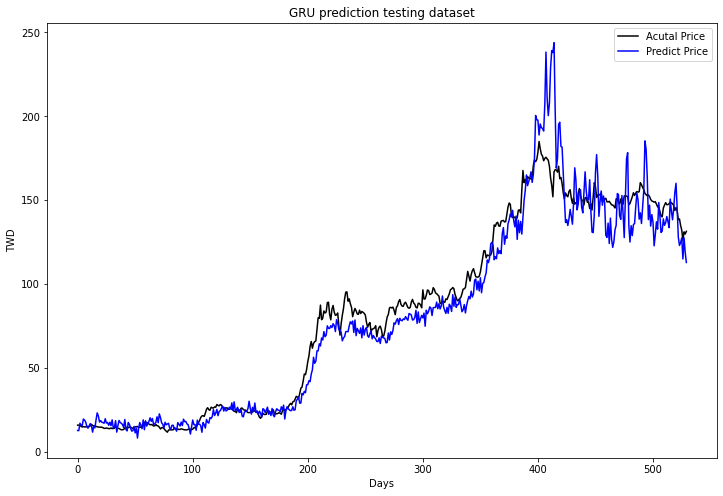

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GRU prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')